In [1]:
import sys
sys.path.append('../scripts')

import fl_algorithms as fla

from matplotlib import pyplot as plt

import numpy as np

from mpl_toolkits.mplot3d import Axes3D

import time
from tqdm import tqdm


In [2]:
def generate_flag_data_noisy(n_pts: int, n: int, flag_type: list, noise: float, seed: int = 1) -> list:
    np.random.seed(seed)

    k = flag_type[-1]
    center_pt = np.linalg.qr(np.random.rand(n, k)-.5)[0][:,:k]

    data = []
    for _ in range(n_pts):
        rand_mat = center_pt + noise*(np.random.rand(n, k)-.5)
        data.append(np.linalg.qr(rand_mat)[0][:,:k])

    return data, center_pt

# Two flags and their mean

In [35]:
def plot_plane(ax: list, xx: np.array, yy: np.array, z: np.array, 
               c: str, point: np.array, a: float, scale: int = 10, 
               label_name: str = '') -> None:
    ax.plot_surface(xx, yy, z, color = c, alpha=a)
    ax.plot([-scale*point[0], scale*point[0]], [-scale*point[1], scale*point[1]], [-scale*point[2], scale*point[2]], color = c, linewidth=2.0, label = label_name)

def plot_flag_small(stacked_data: np.array, data: list, init_pt: np.array, 
                    flag_type: list, colors: list = 2*['tab:blue'], 
                    save_name: str = 'flags_small.pdf', 
                    scales: list = [40, 40,40])-> None:
    # create x,y
    xx, yy = np.meshgrid(range(-10,11), range(-10,11))

    fig = plt.figure()
    axs = []

    axs.append(fig.add_subplot(1,3,1, projection='3d'))
    axs.append(fig.add_subplot(1,3,2, projection='3d'))
    axs.append(fig.add_subplot(1,3,3, projection='3d'))

    max_z = []
    for pt, c, s in zip(data,colors, scales[1:]):
        point = pt[:,0]
        normal = np.cross(pt[:,0], pt[:,1])

        # a plane is a*x+b*y+c*z+d=0
        # [a,b,c] is the normal. Thus, we have to calculate
        # d and we're set
        d = -normal @ point

        # calculate corresponding z
        z = (-normal[0] * xx - normal[1] * yy - d) * 1. /normal[2]

        max_z.append(np.max(z))

        # plot the surface
        plot_plane(axs[0], xx, yy, z, c, point, a = .3, scale = s)
        plot_plane(axs[2], xx, yy, z, c, point, a = .3, scale = s)

        max_z.append(np.max(z))
    max_z = np.max(max_z)

    rfm_out = fla.flag_mean(stacked_data,  
                        flag_type = flag_type, 
                        initial_point = init_pt,
                        return_all = True).point


    point = rfm_out[:,0]
    normal = np.cross(rfm_out[:,0], rfm_out[:,1])
    # a plane is a*x+b*y+c*z+d=0
    # [a,b,c] is the normal. Thus, we have to calculate
    # d and we're set
    d = -normal @ point
    # calculate corresponding z
    z = (-normal[0] * xx - normal[1] * yy - d) * 1. /normal[2]


    # plot the surface
    plot_plane(axs[1], xx, yy, z, 'purple', point, a = .3, scale = scales[0])

    # plot the surface
    plot_plane(axs[2], xx, yy, z, 'purple', point, a = .3, scale = scales[0])

    for ax in axs:
        ax.scatter(0,0,0, color = 'k')

        # Set the plot limits
        ax.set_xlim([-10, 10])
        ax.set_ylim([-10, 10])
        ax.set_zlim([-max_z, max_z])

        # Turn off all axes
        ax.set_axis_off()

        # Set the perspective
        ax.view_init(elev=30, azim=45)  # Set the elevation and azimuth angles
        ax.dist = 10  # Set the distance of the camera from the plot
    plt.tight_layout()
    plt.legend()
    plt.savefig(save_name)
    plt.show()

/var/folders/5m/bv9phk393431tllslwr8yzyw0000gp/T/ipykernel_2408/2341586707.py:78: MatplotlibDeprecationWarning: The dist attribute was deprecated in Matplotlib 3.6 and will be removed two minor releases later.
  ax.dist = 10  # Set the distance of the camera from the plot
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


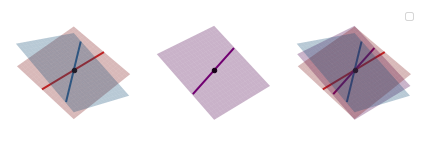

In [36]:
# small example
n_pts = 2
n = 3
flag_type = [1,2]  

n_its = 10

k = flag_type[-1]

noise_data = 2
added_noise = .5

data, center_pt = generate_flag_data_noisy(n_pts, n, flag_type, noise = noise_data, seed = 10)
stacked_data = np.stack(data, axis = 2)
init_pt = np.linalg.qr(center_pt+ added_noise)[0][:,:k]

# plot_data(data, save_name = 'planes_data.pdf') #for seed of 4 [54,23,24]
plot_flag_small(stacked_data, data, init_pt, flag_type, colors = ['tab:blue', 'tab:red'], save_name = 'planes_fl.pdf', scales = [10,12,10])

# Computation time as a function of d and k

In [7]:

def change_d_test(flag_type: list, n_trials: int = 20, 
                  n_pts: int = 10, noise_data: float = .2) -> list:
    k = flag_type[-1]
    
    time_median_mu = []
    time_mean_mu = []

    time_median_std = []
    time_mean_std = []

    ds=  np.arange(5, 500, 5)

    for d in tqdm(ds):

        time_median = []
        time_mean = []
        for _ in range(n_trials):
            data, _ = generate_flag_data_noisy(n_pts, d, flag_type, noise = noise_data)
            stacked_data = np.stack(data, axis = 2)
            init_pt = np.eye(d)[:,:k]

            start = time.time()
            fla.flag_median(stacked_data,  
                                            flag_type = flag_type, 
                                            initial_point_median = init_pt,
                                            return_iters = True,
                                            return_cost = True) 
            time_median.append(time.time()- start)
            
            start = time.time()
            fla.flag_mean(stacked_data,  
                                        flag_type = flag_type, 
                                        initial_point = init_pt,
                                        return_all = True) 
            time_mean.append(time.time()- start)
        
        time_median_mu.append(np.mean(time_median))
        time_mean_mu.append(np.mean(time_mean))

        time_median_std.append(np.std(time_median))
        time_mean_std.append(np.std(time_mean))

    out_data = [ds,
            time_mean_mu, 
            time_median_mu, 
            time_mean_std, 
            time_median_std]

    return out_data

def change_k_test(d: int, n_trials: int = 20, n_pts: int = 10, 
                  noise_data: float = .2) -> list:

    
    time_median_mu = []
    time_mean_mu = []

    time_median_std = []
    time_mean_std = []

    ks=  np.arange(2, d, 2)

    ds = len(ks)*[d]
    ds = np.array(ds)

    for k in tqdm(ks):
        flag_type = [1,k]

        time_median = []
        time_mean = []
        for _ in range(n_trials):
            data, _ = generate_flag_data_noisy(n_pts, d, flag_type, noise = noise_data)
            stacked_data = np.stack(data, axis = 2)
            init_pt = np.eye(d)[:,:k]

            start = time.time()
            fla.flag_median(stacked_data,  
                                            flag_type = flag_type, 
                                            initial_point_median = init_pt,
                                            return_iters = True,
                                            return_cost = True) 
            time_median.append(time.time()- start)
            
            start = time.time()
            fla.flag_mean(stacked_data,  
                                        flag_type = flag_type, 
                                        initial_point = init_pt,
                                        return_all = True) 
            time_mean.append(time.time()- start)
        
        time_median_mu.append(np.mean(time_median))
        time_mean_mu.append(np.mean(time_mean))

        time_median_std.append(np.std(time_median))
        time_mean_std.append(np.std(time_mean))

    out_data = [np.array(ds)-ks,
                time_mean_mu, 
                time_median_mu, 
                time_mean_std, 
                time_median_std]
    
    return out_data 

def make_plots(plot_data: list, save_name: str) -> None:
    
    _, axs = plt.subplots(1,2,figsize=(5, 2))
    
    for ax, p in zip(axs, plot_data):

        ds = p[0]
        time_mean_mu = p[1]
        time_median_mu = p[2]
        time_mean_std = p[3]
        time_median_std = p[4]

        ax.plot(ds, time_mean_mu, label = 'FL-Mean', color='tab:blue')
        ax.fill_between(ds, np.array(time_mean_mu)-np.array(time_mean_std), 
                            np.array(time_mean_mu)+np.array(time_mean_std), 
                            color='tab:blue', alpha=.1)
        ax.plot(ds, time_median_mu, label = 'FL-Median', color='tab:orange')
        ax.fill_between(ds, np.array(time_median_mu)-np.array(time_median_std),
                        np.array(time_median_mu)+(time_median_std), 
                        color='tab:orange', alpha=.1)

    axs[0].set_ylabel('Time (sec)')
    axs[0].set_xlabel('d')
    axs[1].set_xlabel('d-k')

    axs[0].set_title('Fl(1,2;d)')
    axs[1].set_title('Fl(1,k;50)')

    axs[1].legend()
    
    plt.tight_layout()
    
    plt.savefig(save_name, bbox_inches='tight')
      

In [9]:
plt_data = []
plt_data.append(change_d_test(flag_type = [1,2], n_trials = 20))

100%|██████████| 99/99 [16:38<00:00, 10.08s/it]


In [10]:
plt_data.append(change_k_test(50, n_trials = 20))

100%|██████████| 24/24 [50:40<00:00, 126.68s/it]


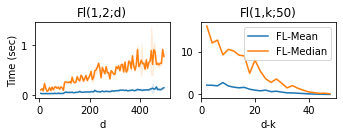

In [32]:
make_plots(plt_data, 'time_plots.pdf')

# Visualize three planes, flag-mean, and euclidean-mean

In [33]:
def plot_data(data, save_name = ''):
    # create x,y
    xx, yy = np.meshgrid(range(-10,10), range(-10,10))

    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')

    # colors = ['tab:blue', 'tab:green', 'tab:orange']
    colors = len(data)*['tab:blue']

    max_z = []
    for pt, c in zip(data,colors):
        point = pt[:,0]
        normal = np.cross(pt[:,0], pt[:,1])

        # a plane is a*x+b*y+c*z+d=0
        # [a,b,c] is the normal. Thus, we have to calculate
        # d and we're set
        d = -normal @ point

        # calculate corresponding z
        z = (-normal[0] * xx - normal[1] * yy - d) * 1. /normal[2]

        max_z.append(np.max(z))

        # plot the surface
        plot_plane(ax, xx, yy, z, c, point, a = .5)
        
        max_z.append(np.max(z))
    max_z = np.max(max_z)

    ax.scatter(0,0,0, color = 'k')

    # Set the plot limits
    ax.set_xlim([-10, 10])
    ax.set_ylim([-10, 10])
    ax.set_zlim([-max_z, max_z])

    # Turn off all axes
    ax.set_axis_off()

    # Set the perspective
    ax.view_init(elev=30, azim=45)  # Set the elevation and azimuth angles
    ax.dist = 8  # Set the distance of the camera from the plot
    plt.tight_layout()
    plt.savefig(save_name)
    plt.show()

def plot_avg(stacked_data, init_pt, flag_type, save_name = ''):

    
    rfm_out = fla.flag_mean(stacked_data,  
                        flag_type = flag_type, 
                        initial_point = init_pt,
                        return_all = True).point

    # plot the surface
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')

    # create x,y
    xx, yy = np.meshgrid(range(-10,10), range(-10,10))

    point = rfm_out[:,0]
    normal = np.cross(rfm_out[:,0], rfm_out[:,1])
    # a plane is a*x+b*y+c*z+d=0
    # [a,b,c] is the normal. Thus, we have to calculate
    # d and we're set
    d = -normal @ point
    # calculate corresponding z
    z = (-normal[0] * xx - normal[1] * yy - d) * 1. /normal[2]

    # plot the surface
    plot_plane(ax, xx, yy, z, 'green', point, a = .5)


    euc_mean = np.mean(stacked_data, axis = 2)
    point = euc_mean[:,0]
    normal = np.cross(euc_mean[:,0], euc_mean[:,1])
    # a plane is a*x+b*y+c*z+d=0
    # [a,b,c] is the normal. Thus, we have to calculate
    # d and we're set
    d = -normal @ point
    # calculate corresponding z
    z = (-normal[0] * xx - normal[1] * yy - d) * 1. /normal[2]


    # plot the surface
    plot_plane(ax, xx, yy, z, 'red', point, a = .5)


    ax.scatter(0,0,0, color = 'k')

    # Turn off all axes
    ax.set_axis_off()

    # Set the perspective
    ax.view_init(elev=30, azim=45)  # Set the elevation and azimuth angles
    ax.dist = 8  # Set the distance of the camera from the plot
    plt.tight_layout()
    plt.savefig(save_name)
    plt.show()

def plot_flag(stacked_data, data, init_pt, flag_type, colors = 3*['tab:blue'], save_name = ''):
    # create x,y
    xx, yy = np.meshgrid(range(-10,10), range(-10,10))

    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')


    max_z = []
    for pt, c in zip(data,colors):
        point = pt[:,0]
        normal = np.cross(pt[:,0], pt[:,1])

        # a plane is a*x+b*y+c*z+d=0
        # [a,b,c] is the normal. Thus, we have to calculate
        # d and we're set
        d = -normal @ point

        # calculate corresponding z
        z = (-normal[0] * xx - normal[1] * yy - d) * 1. /normal[2]

        max_z.append(np.max(z))

        # plot the surface
        plot_plane(ax, xx, yy, z, c, point, a = .2)

        max_z.append(np.max(z))
    max_z = np.max(max_z)

    rfm_out = fla.flag_mean(stacked_data,  
                        flag_type = flag_type, 
                        initial_point = init_pt,
                        return_all = True).point


    point = rfm_out[:,0]
    normal = np.cross(rfm_out[:,0], rfm_out[:,1])
    # a plane is a*x+b*y+c*z+d=0
    # [a,b,c] is the normal. Thus, we have to calculate
    # d and we're set
    d = -normal @ point
    # calculate corresponding z
    z = (-normal[0] * xx - normal[1] * yy - d) * 1. /normal[2]


    # plot the surface
    plot_plane(ax, xx, yy, z, 'green', point, a = .5)


    ax.scatter(0,0,0, color = 'k')

    # Set the plot limits
    ax.set_xlim([-10, 10])
    ax.set_ylim([-10, 10])
    ax.set_zlim([-max_z, max_z])

    # Turn off all axes
    ax.set_axis_off()

    # Set the perspective
    ax.view_init(elev=30, azim=45)  # Set the elevation and azimuth angles
    ax.dist = 8  # Set the distance of the camera from the plot
    plt.tight_layout()
    plt.savefig(save_name)
    plt.show()

def plot_euc(stacked_data, data, colors = 3*['tab:blue'], save_name = ''):
    # create x,y
    xx, yy = np.meshgrid(range(-10,10), range(-10,10))

    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')


    max_z = []
    for pt, c in zip(data,colors):
        point = pt[:,0]
        normal = np.cross(pt[:,0], pt[:,1])

        # a plane is a*x+b*y+c*z+d=0
        # [a,b,c] is the normal. Thus, we have to calculate
        # d and we're set
        d = -normal @ point

        # calculate corresponding z
        z = (-normal[0] * xx - normal[1] * yy - d) * 1. /normal[2]

        max_z.append(np.max(z))

        # plot the surface
        plot_plane(ax, xx, yy, z, c, point, a = .2)

        max_z.append(np.max(z))
    max_z = np.max(max_z)

    euc_mean = np.mean(stacked_data, axis = 2)
    point = euc_mean[:,0]
    normal = np.cross(euc_mean[:,0], euc_mean[:,1])
    # a plane is a*x+b*y+c*z+d=0
    # [a,b,c] is the normal. Thus, we have to calculate
    # d and we're set
    d = -normal @ point
    # calculate corresponding z
    z = (-normal[0] * xx - normal[1] * yy - d) * 1. /normal[2]


    # plot the surface
    plot_plane(ax, xx, yy, z, 'red', point, a = .5)


    ax.scatter(0,0,0, color = 'k')

    # Set the plot limits
    ax.set_xlim([-10, 10])
    ax.set_ylim([-10, 10])
    ax.set_zlim([-max_z, max_z])

    # Turn off all axes
    ax.set_axis_off()

    # Set the perspective
    ax.view_init(elev=30, azim=45)  # Set the elevation and azimuth angles
    ax.dist = 8 # Set the distance of the camera from the plot
    plt.tight_layout()
    plt.savefig(save_name)
    plt.show()


/var/folders/5m/bv9phk393431tllslwr8yzyw0000gp/T/ipykernel_2408/4116870190.py:44: MatplotlibDeprecationWarning: The dist attribute was deprecated in Matplotlib 3.6 and will be removed two minor releases later.
  ax.dist = 8  # Set the distance of the camera from the plot


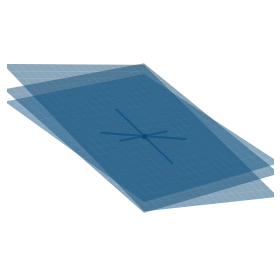

/var/folders/5m/bv9phk393431tllslwr8yzyw0000gp/T/ipykernel_2408/4116870190.py:99: MatplotlibDeprecationWarning: The dist attribute was deprecated in Matplotlib 3.6 and will be removed two minor releases later.
  ax.dist = 8  # Set the distance of the camera from the plot


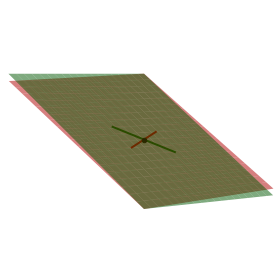

/var/folders/5m/bv9phk393431tllslwr8yzyw0000gp/T/ipykernel_2408/4116870190.py:226: MatplotlibDeprecationWarning: The dist attribute was deprecated in Matplotlib 3.6 and will be removed two minor releases later.
  ax.dist = 8 # Set the distance of the camera from the plot


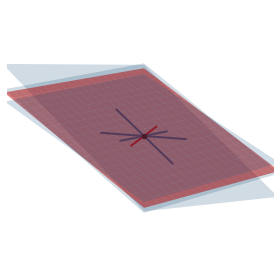

/var/folders/5m/bv9phk393431tllslwr8yzyw0000gp/T/ipykernel_2408/4116870190.py:165: MatplotlibDeprecationWarning: The dist attribute was deprecated in Matplotlib 3.6 and will be removed two minor releases later.
  ax.dist = 8  # Set the distance of the camera from the plot


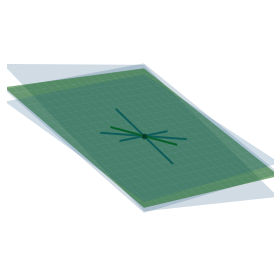

In [34]:
#complex example

n_pts = 3
n = 3
flag_type = [1,2]  

n_its = 10

k = flag_type[-1]

noise_data = 1.2
added_noise = .5

data, center_pt = generate_flag_data_noisy(n_pts, n, flag_type, noise = noise_data, seed = 3)
stacked_data = np.stack(data, axis = 2)
init_pt = np.linalg.qr(center_pt+ added_noise)[0][:,:k]

plot_data(data, save_name = 'planes_data.pdf')
plot_avg(stacked_data, init_pt, flag_type, save_name = 'planes_avg.pdf')
plot_euc(stacked_data, data, colors = 3*['tab:blue'], save_name = 'planes_euc.pdf')
plot_flag(stacked_data, data, init_pt, flag_type, colors = 3*['tab:blue'], save_name = 'planes_fl.pdf')